# Exploring Toronto's Neighborhoods

In this lab, I utilized wikipedia and foursquare to obtain information on the venues surounding Toronto. Then, the venues were grouped by neighborhood and the neighboorhoods were clustered into groups based on similarity.

In [136]:
#import the required libraries
import numpy as np
import pandas as pd

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Libraries installed!")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries installed!


# Part 1

In [153]:
#wiki url
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#create table from wiki
raw_toronto_data = pd.read_html(url, header=0)[0]

#clean table by removing N/A
toronto_data = raw_toronto_data[raw_toronto_data.Borough != "Not assigned"]
for index, row in toronto_data.iterrows():
    if row['Neighbourhood'] == "Not assigned":
        row['Neighbourhood'] = row['Borough']
        print("Removed Not assigned!")

#Combine Neighborhoods based on Postcode
clean_td = toronto_data.groupby(['Postcode','Borough'])['Neighbourhood'].apply(", ".join).reset_index()
clean_td.head()




Removed Not assigned!


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


The above code takes data from the wiki site's table relating to Canadian postal codes and neighborhoods, then cleans the data to remove N/A and group equivalent postal codes.

In [154]:
clean_td.shape

(103, 3)

# Part 2

In [155]:
#Obtain Lat/Lon of each postcode
toronto_coord = pd.read_csv("http://cocl.us/Geospatial_data")
toronto_coord.rename(columns= {"Postal Code": "Postcode"}, inplace = True)
toronto_data = pd.merge(clean_td, toronto_coord)
toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Part 3

In [156]:
#Pull only Toronto Boroughs
toronto_data = toronto_data[toronto_data['Borough'].str.contains("Toronto")]
toronto_data.reset_index(drop = True, inplace = True)
toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


A dataframe containing Toronto postal codes with their respective boroughs, neighborhoods, and coordinates it now created.

In [157]:
#Get Toronto coordinates using geolocator
address = "Toronto, ON"
geolocator = Nominatim(user_agent = "toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Make general Toronto map
map_toronto = folium.Map(location = [latitude, longitude], zoom_start = 10)

#add markers to map for each neighborhood/borough
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = 'Neighborhood: {}     Borough: {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        parse_html = False).add_to(map_toronto)

map_toronto

In [201]:
# The code was removed by Watson Studio for sharing.

#### The following code will use foursquare to obtain information on Toronto venues.

In [191]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Function to obtain nearby values given name, lat/lon, and radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes): 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [194]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'])

In [195]:
print(toronto_venues.shape)
toronto_venues.head()

(1716, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Domino's Pizza,43.679058,-79.297382,Pizza Place


In [197]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,86,86,86,86,86,86
"Chinatown, Grange Park, Kensington Market",90,90,90,90,90,90
Christie,17,17,17,17,17,17


The above dataframe shows the number of venues that were returned for each neighborhood list.

In [198]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


### Analyzing Each Neighborhood

In [165]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
toronto_onehot.shape

(1716, 238)

In [167]:
#group neighborhoods and take the mean of the frequency of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.02,...,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.01
1,Berczy Park,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.055556,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00


In [168]:
toronto_grouped.shape

(39, 238)

The following code sorts and creates a new df with the top 10 venues for each neighborhood list.



In [199]:
#Function determines the most common venues for each row
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Clothing Store,Burger Joint,Sushi Restaurant,Hotel,Asian Restaurant,Thai Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Steakhouse,Seafood Restaurant,Farmers Market,Cheese Shop,Café,Bistro
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Farmers Market,Burrito Place,Spa,Butcher,Pizza Place,Smoke Shop,Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Plane,Coffee Shop,Sculpture Garden


### Cluestering Neighborhoods Based on Most Common Venues

k =  1 Cost =  3.6426853833657935
k =  2 Cost =  2.6655558837393007
k =  3 Cost =  2.1614343991480123
k =  4 Cost =  1.7168890116446058
k =  5 Cost =  1.4707590881594075
k =  6 Cost =  1.3299754831401254
k =  7 Cost =  1.2325837866449536
k =  8 Cost =  1.1097382966473743
k =  9 Cost =  1.0485829777408726
k =  10 Cost =  0.9529405235558577


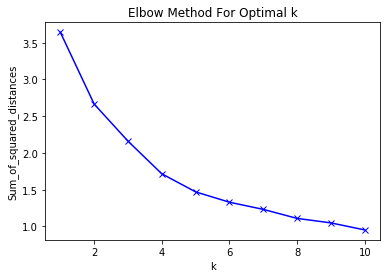

In [170]:
#Find best k value
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = []
for k in range(1, 11):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0, n_init =12).fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    K.append(k)
    print("k = ", k, "Cost = ", kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


A value of k = 5 was chosen as the elbow appears to be at k = 5.

In [182]:
#Cluster with k = 5
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, init="k-means++", random_state=0, n_init =12).fit(toronto_grouped_clustering)

#Map clusters
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add clustering labels
neighborhoods_venues_sorted.drop(columns= ['Cluster Labels'], inplace = True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


It appears as you move away from the coast the types of neighborhoods start to differentiate. Its possible the areas closer to the coast tend to be tourist locations, and thus have similar types of venues relative to the neighborhoods farther from the coast.

### Examining Clusters

In [183]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Health Food Store,Other Great Outdoors,Pizza Place,Pub,Trail,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
1,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Grocery Store,Restaurant,Pub,Pizza Place,Liquor Store
2,East Toronto,0,Park,Brewery,Burrito Place,Fish & Chips Shop,Steakhouse,Pub,Ice Cream Shop,Fast Food Restaurant,Italian Restaurant,Movie Theater
3,East Toronto,0,Café,Coffee Shop,Gastropub,Bakery,Italian Restaurant,Brewery,American Restaurant,Yoga Studio,Seafood Restaurant,Sandwich Place
5,Central Toronto,0,Park,Convenience Store,Sandwich Place,Food & Drink Shop,Department Store,Asian Restaurant,Hotel,Breakfast Spot,Gym / Fitness Center,Gym
6,Central Toronto,0,Coffee Shop,Cosmetics Shop,Sporting Goods Shop,Chinese Restaurant,Salon / Barbershop,Burger Joint,Restaurant,Rental Car Location,Café,Yoga Studio
7,Central Toronto,0,Dessert Shop,Sandwich Place,Pizza Place,Café,Coffee Shop,Sushi Restaurant,Gym,Italian Restaurant,Pharmacy,Dance Studio
9,Central Toronto,0,Coffee Shop,Pub,Supermarket,Sushi Restaurant,Vietnamese Restaurant,Light Rail Station,Liquor Store,Pizza Place,American Restaurant,Bagel Shop
11,Downtown Toronto,0,Coffee Shop,Restaurant,Italian Restaurant,Park,Market,Pizza Place,Pub,Bakery,Café,Breakfast Spot
12,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Men's Store,Burger Joint,Café,Hotel,Mediterranean Restaurant


In [184]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,1,Playground,Women's Store,Department Store,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [185]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,2,Park,Trail,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
23,Central Toronto,2,Trail,Park,Sushi Restaurant,Jewelry Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store


In [186]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Pool,Garden,Women's Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [187]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Park,Photography Studio,Bus Line,Swim School,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


As you can see, cluster 1 had many more neighborhood list points realtive to the other clusters. This can be explained by the majority of neighborhoods in cluster 1 having very general venues such as coffe shops, cafes, gyms, and bars, while the remaining cluster neighborhoods did not contain these venues. I believe if further analysis were to be completed and ranks were given to each column based on the rank of most common (1, 2, 3, 4, etc.), then the clusters would be more equal in terms of points in each cluster.

In addition, I believe a future project that grouped similar types of venues (ex. coffee shop =  cafe, Bar = Beer bar, etc.) could potentially group the clusters more efficiently.